# Packages

In [11]:
import ee
import geemap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights'

The DMSP-OLS sensors lacked on-board calibration, so there are noticeable variations from satellite to satellite. In order to adequately compare nighttime lights data across satellites, they must be calibrated.

The initial paper cited outlines the steps the authors took. What’s important for our purposes here, is that they derived a set of coefficients that, when applied to each satellite in the DMSP series, corrects for the sensor variation and allows us to more accurately compare data.

These coefficients map to the formula: $ X' = C_0 + C_1 * X + C_2 * X^2 $

Where:
- $X$: The input image, represented as a 2D matrix (recall these images are panchromatic so there is only one channel of light)
- $C_0, C_1, C_2$: The calibration coefficients that are assigned to each satellite
- $X'$: The calibrated image

The initial paper was written in 2009, even though DMSP-OLS data for several years after that are available publicly. We can get a more recent series of coefficients, through 2012, here (using the same method as the original 2009 paper):

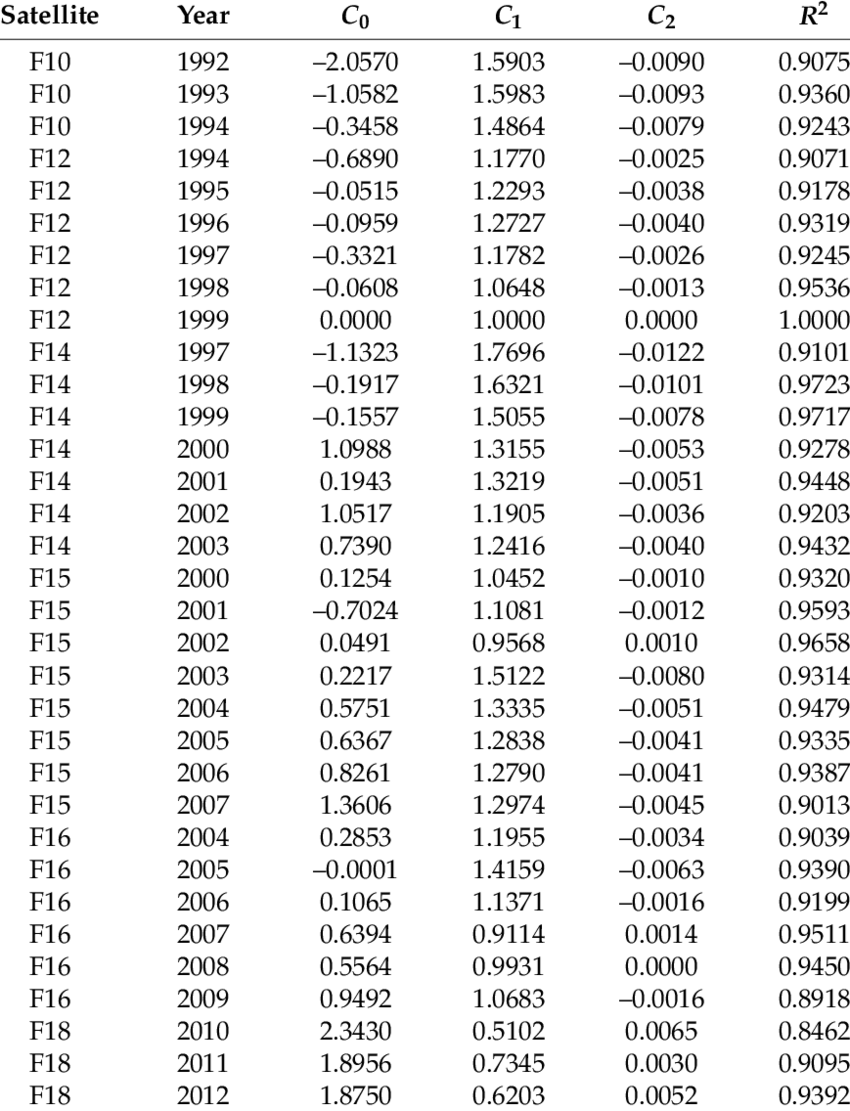

**Note**: this method is fine for purposes of this tutorial, but it’s worth mentioning that there are several other methods to conduct this calibration as well. As you will see, no calibration is 100% perfect.

# Apply calibration to a single annual composite: 1996

In [12]:
# Map parameters
lat = 38.9072
lon = -77.0369
zoom = 10

# Initialize map
map1 = geemap.Map(center = [lat, lon], zoom = zoom)
map1.add_basemap('SATELLITE')

# Get 1996 composite
dmsp1996 = ee.Image('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996').select('stable_lights')
map1.addLayer(dmsp1996.mask(dmsp1996), {}, 'DMSP-OLS 1996', opacity = 0.75)
map1.addLayerControl()
map1

Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

For 1996, there is only one satellite, F12, so we can reference the appropriate coefficients for F121996 from our table above:
- $C_0$ = -0.0959
- $C_1$ = 1.2727
- $C_2$ = -0.0040

GEE has an `.expression()` method which allows us to plug our formula in with these coefficients and get an adjusted image. We add our coefficients to the appropriate terms of the polynomial and set our input image as the X variable.

In [13]:
dmsp1996_clbr = dmsp1996.expression('-0.0959 + (1.2727 * X) + (-0.0040 * X * X)',
                {'X': dmsp1996.select('stable_lights')})
dmsp1996_clbr

This calibration adjusts the value of the Digital Number (DN)and in some cases, it will cause a pixel’s value to go above 63. We also have pixels with DN’s of less than 6. We’ll cap the DNs at 63 and replace any values below 6 with 0s.

In [14]:
# Calibrate image
dmsp1996_clbr = dmsp1996_clbr.where(dmsp1996_clbr.gt(63), 63).where(dmsp1996_clbr.lte(6), 0)
dmsp1996_clbr

In [15]:
# Create a clipped version of the original image so we can compare distributions
dmsp1996_clip = dmsp1996.where(dmsp1996.gt(63), 63).where(dmsp1996.lte(6), 0)
dmsp1996_clip

# Compare the calibrated images with a plot

A good way to compare a two images is with the distribution of the DN values, such as a basic histogram or probability density plot. Google Earth Engine has options for plotting images in the JavaScript editor, but they’re not available for the Python API. So we’ll have to do a couple steps to make a plot.

We'll use a bounding box that covers Washington DC and Baltimore to define our region and extract a numerical array.

In [16]:
# Define our rectangle that covers DC/Baltimore area
myPolyGeom = ee.Geometry.Rectangle([-78.243025, 38.317633,-75.724436, 39.521098]).toGeoJSON()

# Convert both the clipped DMSP-OLS 1996 layer and the calibrated layer to numpy arrays
dmsp1996_arr = geemap.ee_to_numpy(dmsp1996_clip, region = myPolyGeom)
dmsp1996_clbr_arr = geemap.ee_to_numpy(dmsp1996_clbr, region = myPolyGeom)
dmsp1996_clbr_arr

array([[[ 6.1676],
        [ 6.1676],
        [ 7.3963],
        ...,
        [27.0602],
        [31.351 ],
        [33.4484]],

       [[ 6.1676],
        [ 6.1676],
        [ 6.1676],
        ...,
        [27.0602],
        [31.351 ],
        [34.4851]],

       [[ 6.1676],
        [ 6.1676],
        [ 6.1676],
        ...,
        [25.9675],
        [29.2216],
        [31.351 ]],

       ...,

       [[ 7.3963],
        [ 7.3963],
        [ 9.8297],
        ...,
        [ 9.8297],
        [11.0344],
        [12.2311]],

       [[ 7.3963],
        [ 7.3963],
        [ 8.617 ],
        ...,
        [ 7.3963],
        [ 8.617 ],
        [ 9.8297]],

       [[ 8.617 ],
        [ 8.617 ],
        [ 8.617 ],
        ...,
        [ 7.3963],
        [ 7.3963],
        [ 8.617 ]]])

In [17]:
dmsp1996_arr.flatten().shape

(44238,)

We’ll get into the plotting packages available in a later tutorial when we focus on creating plots. For now, we’ll just use the `seaborn` package and the `matplotlib.pyplot` packages to create a simple probability density plot that compares the distribution of our two layers.

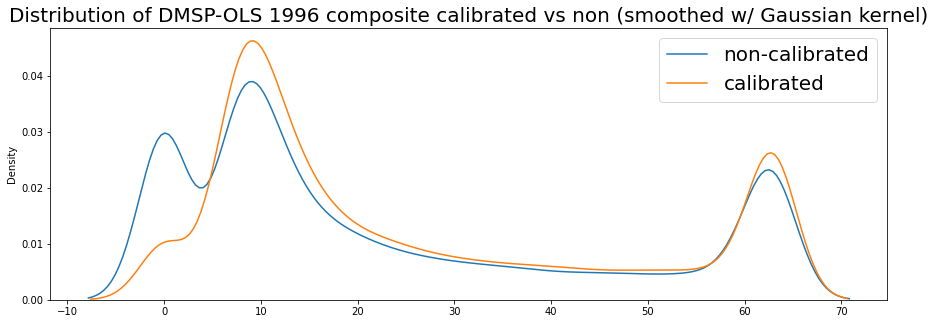

In [18]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.kdeplot(dmsp1996_arr.flatten(), label = 'non-calibrated', legend = True, ax = ax)
sns.kdeplot(dmsp1996_clbr_arr.flatten(), label = 'calibrated', legend = True, ax = ax)
plt.legend(fontsize = 20)
plt.title('Distribution of DMSP-OLS 1996 composite calibrated vs non (smoothed w/ Gaussian kernel)', fontsize = 20)

plt.show()

Brief observations: You can see that while both layers show a similar distribution, the calibration impacts the distribution somewhat.

# Thinking programmically: creating a function to conduct calibration

We just calibrated a single annual composite by hard-coding the expression to show what’s happening, but in general this is a **bad idea**. Rather, we should create a function, which is better for two very important reasons:
- functions are more efficient and reduce repetition when coding (especially if you want to a calibrate many images)
- they reduce the chance of human error when hand-writing or cutting-and-pasting data, such as our calibration coefficients or satellite names. Imagine the potential for error if you had to hand-copy each calibration coefficient every time you wrote the expression.

We’ve created a .csv file of our calibration coeffients, saved in this GitHub repo at `files/Elvidge_DMSP_intercalib.csv`. We’re going to create a series of functions that get the satellite name and year from the Image itself, look up that particular satellite-year’s calibration coefficients from our table, apply them to the image, and finally, clip the low and high DN values as we did before.

We can then use this function on any Image in our ImageCollection to return a calibrated and clipped version.

In [19]:
# Load the file
coef = pd.read_csv(r'C:\Users\gilramolete\OneDrive - UNIONBANK of the Philippines\Documents 1\Open Nighttime Lights\files\Elvidge_DMSP_intercalib_coef.csv')
coef

,satellite,year,c0,c1,c2
0,F10,1992,-2.0570,1.5903,-0.0090
1,F10,1993,-1.0582,1.5983,-0.0093
2,F10,1994,-0.3458,1.4864,-0.0079
3,F12,1994,-0.6890,1.1770,-0.0025
4,F12,1995,-0.0515,1.2293,-0.0038
5,F12,1996,-0.0959,1.2727,-0.0040
6,F12,1997,-0.3321,1.1782,-0.0026
7,F12,1998,-0.0608,1.0648,-0.0013
8,F12,1999,0.0000,1.0000,0.0000
9,F14,1997,-1.1323,1.7696,-0.0122


In [20]:
def get_coefs(img, coefdata = coef):
    """
    Get an image, its name, and return its coefficients.
    """

    imgID = img.id().getInfo()
    idx = coefdata['satellite'] + coefdata['year'].astype(str) == imgID
    return coefdata.loc[idx, ['c0', 'c1', 'c2']].values[0]

def calibrate_img(img):
    """
    Wraps the ee.Image native "expression" function and passess the image coefficients as arguments to return the calibrated image.
    """

    c0, c1, c2 = get_coefs(img)
    return img.expression('c0 + (c1 * X) + (c2 * X**2)', {'X': img, 'c0': c0, 'c1': c1, 'c2': c2})

def clip_img(img, upper_thresh = 63, upper_set = 63, lower_thresh = 6, lower_set = 0):
    """
    Clips the image.
    """
    return img.where(img.gt(upper_thresh), upper_set).where(img.lte(lower_thresh), lower_set)

def calibrate_and_clip(img):
    """
    Wrap all into a single function.
    """
    return clip_img(calibrate_img(img))

Now that we have created our single function, `calibrate_and_clip()` that takes a single input, an ee.Image object, we can apply it to any Image we’ve created, without having to manually look up the calibration coefficients or even the satellite name. We can get that directly from the image object itself!

For example, let’s take our 1996 composite (which we created above), and return a calibrated image, just as before, but this time using our new function.

In [22]:
# Create a calibrated and clipped version from our 1996 composite but with our new function
dmsp1996_clbr2 = calibrate_and_clip(dmsp1996)

# Create an array from this new image, just as before, so we can plot the distribution
dmsp1996_clbr2_arr = geemap.ee_to_numpy(dmsp1996_clbr2, region = myPolyGeom)
dmsp1996_clbr2_arr

array([[[ 6.1676],
        [ 6.1676],
        [ 7.3963],
        ...,
        [27.0602],
        [31.351 ],
        [33.4484]],

       [[ 6.1676],
        [ 6.1676],
        [ 6.1676],
        ...,
        [27.0602],
        [31.351 ],
        [34.4851]],

       [[ 6.1676],
        [ 6.1676],
        [ 6.1676],
        ...,
        [25.9675],
        [29.2216],
        [31.351 ]],

       ...,

       [[ 7.3963],
        [ 7.3963],
        [ 9.8297],
        ...,
        [ 9.8297],
        [11.0344],
        [12.2311]],

       [[ 7.3963],
        [ 7.3963],
        [ 8.617 ],
        ...,
        [ 7.3963],
        [ 8.617 ],
        [ 9.8297]],

       [[ 8.617 ],
        [ 8.617 ],
        [ 8.617 ],
        ...,
        [ 7.3963],
        [ 7.3963],
        [ 8.617 ]]])

Now let’s compare the density plots of our new calibrated image `dmsp1996_clbr2` with the calibration we did manually before, `dmsp1996_clbr` – they should be exactly the same!

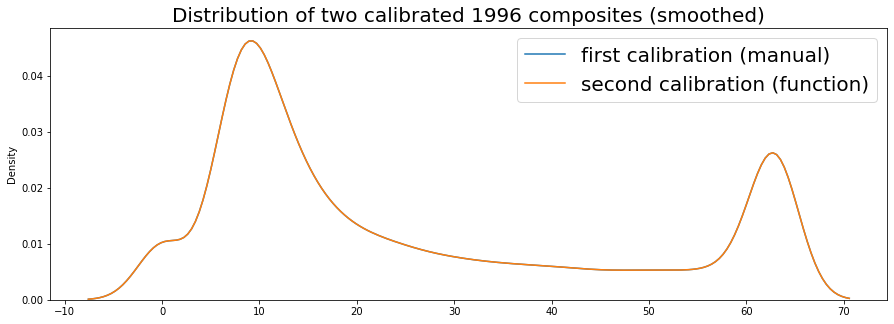

In [24]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.kdeplot(dmsp1996_clbr_arr.flatten(), label = 'first calibration (manual)', legend = True, ax = ax)
sns.kdeplot(dmsp1996_clbr2_arr.flatten(), label = 'second calibration (function)', legend = True, ax = ax)
plt.legend(fontsize = 20)
plt.title('Distribution of two calibrated 1996 composites (smoothed)', fontsize = 20)

plt.show()

Indeed, they are exactly the same!

In fact, the difference when subracting one array from the other is exactly zero for element in the array (i.e. pixel in the image):

In [25]:
(dmsp1996_clbr_arr - dmsp1996_clbr2_arr).sum().astype(int)

0

Let's compare another year: 2007. This year has data from two overlapping satellites: F15 and F16, so can actually compare how calibration impacts them both.

First we’ll retrieve and plot the intial composites:

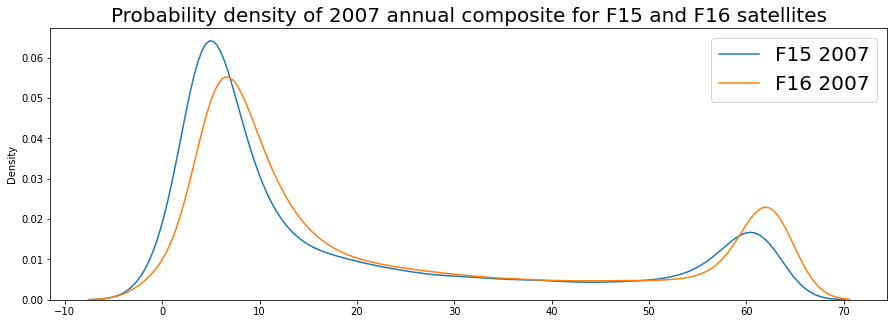

In [26]:
# Initial images
dmspF152007 = ee.Image('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F152007').select('stable_lights')
dmspF162007 = ee.Image('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F162007').select('stable_lights')

# Convert to arrays and plot
dmspF152007_arr = geemap.ee_to_numpy(dmspF152007, region = myPolyGeom)
dmspF162007_arr = geemap.ee_to_numpy(dmspF162007, region = myPolyGeom)

fig, ax = plt.subplots(figsize = (15, 5))
sns.kdeplot(dmspF152007_arr.flatten(), label = 'F15 2007', legend = True, ax = ax)
sns.kdeplot(dmspF162007_arr.flatten(), label = 'F16 2007', legend = True, ax = ax)
plt.legend(fontsize = 20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites', fontsize = 20)

plt.show()

While they are similar, you can see there is indeed a noticeable difference, particularly in lower and upper ranges, for example they diverge above about 50 DN.

If you were comparing city lights, which would be in that upper range range, above 50 DN, you might see a difference that is attributed not to actual observed light, but to the difference in sensors.

Now let’s calibrate them both.

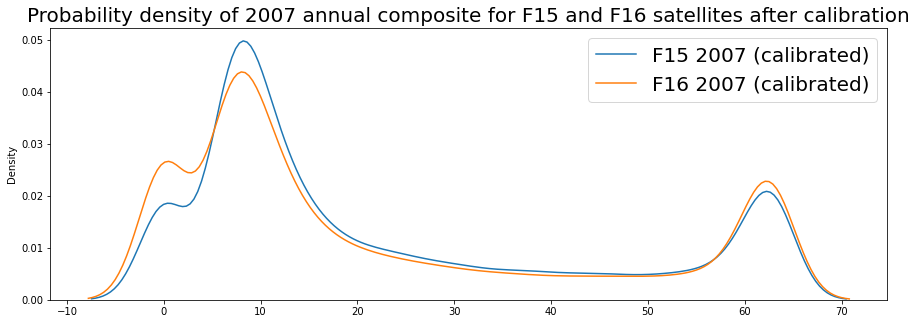

In [27]:
# calibrate both images
dmspF152007_clbr = calibrate_and_clip(dmspF152007)
dmspF162007_clbr = calibrate_and_clip(dmspF162007)

# convert to arrays and plot histograms
dmspF152007_clbr_arr = geemap.ee_to_numpy(dmspF152007_clbr, region=myPolyGeom)
dmspF162007_clbr_arr = geemap.ee_to_numpy(dmspF162007_clbr, region=myPolyGeom)

fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(dmspF152007_clbr_arr.flatten(), label = 'F15 2007 (calibrated)',legend = True, ax = ax)
sns.kdeplot(dmspF162007_clbr_arr.flatten(), label = 'F16 2007 (calibrated)',legend = True, ax = ax)
plt.legend(fontsize = 20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites after calibration', fontsize = 20)
plt.show()

They are not a perfect match (keep in mind, the calibration is still just an approximation!) but you can see that noticeable dviergence is now gone and the two images are very nearly aligned in the top part of the range and closer at the very low end of the range.

Calibration has made our composites across satellites more comparable!

This just scratched the surface in terms of intercalibration, which can be complicated as the methods and models get more complex. But hopefully this simple calibration allows you to get a more comparable time series with the DMSP-OLS data.